In [1]:
%load_ext autoreload
%autoreload 2

from policy_iteration import *
import numpy as np
from tqdm import tqdm

# Day 6 - Dynamic Programming

## Policy Iteration

* $Policy\ iteration$ is the process of alternating policy evaluation and policy improvement

$$
\pi_0\overset{E}{\longrightarrow}v_{\pi_0}\overset{I}{\longrightarrow}\pi_1\overset{E}{\longrightarrow}v_{\pi_1}\overset{I}{\longrightarrow}\pi_2\overset{E}{\longrightarrow}\dots\overset{I}{\longrightarrow}\pi_*\overset{E}{\longrightarrow}v_{\pi_*}
$$
* This is guaranteed to be a strict improvement at each step, until it reaches the optimal policy, which is guaranteed to happen in a finite number of iterations in a finite MDP
* This can often converge in very few iterations

In [2]:
num_states = 16
num_actions = 4
transitions = np.zeros((num_states, num_states, num_actions))
for s in range(num_states):
    up, right, down, left = s-4, s+1, s+4, s-1
    if s == 0:
        up, right, down, left = 0, 0, 0, 0
    if s in [1, 2, 3]:
        up = s
    if s in [3, 7, 11]:
        right = s
    if s in [12, 13, 14]:
        down = s
    if s in [4, 8, 12]:
        left = s
    if s == 14:
        right = 0
    if s == 11:
        down = 0
    if s == 13:
        down = 15
    if s == 15:
        up = 13
        right = 14
        down = 15
        left = 12
    transitions[s,up,0] = 1
    transitions[s,right,1] = 1
    transitions[s,down,2] = 1
    transitions[s,left,3] = 1
rewards = np.ones((num_states, num_states, num_actions)) * -1.0
rewards[0,:,:] = 0.0
discount = 1.0
policy = np.ones((num_states, num_actions)) / 4.0 # Order: up, right, down, left

iterator = PolicyIteration(transitions, rewards, discount, policy)
iterator.find_optimal_policy()

values = np.zeros((num_states+4, 1))
values[:num_states,:] = iterator.values.copy()
values[num_states-1,:] = iterator.values[0]
values[17] = iterator.values[15]
values = values.reshape(5,4)
print(values)
policy = np.zeros((num_states+4, 1))
policy[:num_states,:] = np.argmax(iterator.policy, axis=2)
policy[num_states-1,:] = np.argmax(iterator.policy[0], axis=1)
policy[17] = np.argmax(iterator.policy[15], axis=1)
policy = policy.reshape(5,4)
print(policy)

[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]
 [ 0. -2.  0.  0.]]
[[0. 3. 3. 2.]
 [0. 0. 0. 2.]
 [0. 0. 1. 2.]
 [0. 1. 1. 0.]
 [0. 1. 0. 0.]]


### $Exercise\ \mathcal{4.4}$

#### The policy iteration algorithm on page 80 has a subtle bug in that it may never terminate if the policy continually switches between two or more policies that are equally good. This is okay for pedagogy, but not for actual use. Modify the pseudocode so that convergence is guaranteed.

The policy may oscillate if the $\operatorname{argmax}$ breaks ties randomly. To fix this, ties should be broken deterministically, for example by always choosing the first of the maximizing actions.

### $Exercise\ \mathcal{4.5}$

#### How would policy iteration be defined for action values? Give a complete algorithm for computing $q_\pi$, analogous to that on page 80 for computing $v_\pi$. Please pay special attention to this exercise, because the ideas involved will be used throughout the rest of the book.

1. Initialization <br>
   $Q(s,a)\in\mathbb R$ and $\pi(s)\in \mathcal{A}(s)$ arbitrarily for all $s\in\mathcal{S}, a\in\mathcal{A};\, Q(terminal, a)\doteq0$ for all $a\in\mathcal{A}$

2. Policy Evaluation <br>
   Loop: <br>
   &emsp;$\Delta\leftarrow0$<br>
   &emsp;Loop for each $s\in\mathcal{S},\ a\in\mathcal{A}$:<br>
   &emsp;&emsp;$q\leftarrow Q(s,a)$<br>
   &emsp;&emsp;$Q(s,a)\leftarrow \sum_{s',r}p(s',r|s,a)[r+\gamma\sum_{a'}\pi(a'|s')Q(s',a')]$<br>
   &emsp;&emsp;$\Delta\leftarrow\operatorname{max}(\Delta,|v-Q(s,a)|)$<br>
   until $\Delta<\theta$ (a small positive number determining the accuracy of estimation)<br>

3. Policy Improvement<br>
   $policy$-$stable\leftarrow true$<br>
   For each $s\in\mathcal{S}$:<br>
   &emsp;$old$-$action\leftarrow\pi(s)$<br>
   &emsp;$\pi(s)\leftarrow\operatorname{arg}\underset{a}{\operatorname{max}}Q(s,a)$<br>
   &emsp;$policy$-$stable\leftarrow old$-$action=\pi(s)$<br>
   If $policy$-$stable$, then stop and return $Q\approx q_*$ and $\pi\approx\pi_*;$ else go to 2

### $Exercise\ \mathcal{4.6}$

#### Suppose you are restricted to considering only policies that are $\varepsilon$-soft, meaning that the probability of selecting each action in each state, $s$, is at least $\varepsilon/|\mathcal{A}(s)|$. Describe qualitatively the changes that would be required in each of the steps 3, 2, and 1, in that order, of the policy iteration algorithm for $v_*$ on page 80.

In the third step, the values of $\pi(a|s)$ would have to be set to $\frac{\varepsilon}{|\mathcal{A}(s)|}$ first, then for the best action $a_*$, $\pi(a_*|s)$ would have to be increased by $1-\varepsilon$.  
In the second step, the new value estimate would have to also sum over all actions, as $\pi(s)$ is now replaced with $\pi(a|s)$.  
In the first step, $\pi(a|s)$ would have to be initialized for all $s\in\mathcal{S},\ a\in\mathcal{A}$, such that $\sum_a\pi(a|s)=1$.

### $Exercise\ \mathcal{4.7}\ (programming)$

#### Write a program for policy iteration and re-solve Jack’s car rental problem with the following changes. One of Jack’s employees at the first location rides a bus home each night and lives near the second location. She is happy to shuttle one car to the second location for free. Each additional car still costs \\$2, as do all cars moved in the other direction. In addition, Jack has limited parking space at each location. If more than 10 cars are kept overnight at a location (after any moving of cars), then an additional cost of \\$4 must be incurred to use a second parking lot (independent of how many cars are kept there). These sorts of nonlinearities and arbitrary dynamics often occur in real problems and cannot easily be handled by optimization methods other than dynamic programming. To check your program, first replicate the results given for the original problem.

In [3]:
from math import factorial, exp

poissons = {
    2: {},
    3: {},
    4: {},
}

poissons_n_or_more = {
    2: {},
    3: {},
    4: {},
}



def poisson(lmbd, n):
    res = poissons[lmbd].get(n)
    if res is None:
        res = exp(-lmbd) * ((lmbd ** n) / factorial(n))
        poissons[lmbd][n] = res
    return res


def poisson_n_or_more(lmbd, n):
    res = poissons_n_or_more[lmbd].get(n)
    if res is None:
        res = 1 - sum(poisson(lmbd, m) for m in range(n))
        poissons_n_or_more[lmbd][n] = res
    return res

In [4]:
# A state is turned from a number into the quantities of cars at each location as
# if the number of cars in the first location is rows, and the numbers of cars at
# the second location is rows. So if there are 10 cars at the first location, and
# 7 at the second, it is state 10 * 21 + 7 = 217. The formula is then:
# state = n_cars_1 * 21 + n_cars_2.
num_states = 21 * 21
num_actions = 11
discount = 0.9
lmbd_req1 = 3
lmbd_req2 = 4
lmbd_ret1 = 3
lmbd_ret2 = 2

transitions = np.zeros((num_states, num_states, num_actions))
rewards = np.zeros_like(transitions) - 2 * np.abs(np.arange(-5, 6))
policy = np.ones((num_states, num_actions), dtype=float) / num_actions

for s in tqdm(range(num_states), desc="s"):
    # Number of cars in first location
    s1 = s // 21
    # Number of cars in second location
    s2 = s % 21
    for a in range(num_actions):
        raw_cars_moved = a - 5
        cars_moved = min(s1, raw_cars_moved)
        cars_moved = max(-s2, cars_moved)
        c1am = min(20, s1 - cars_moved)
        c2am = min(20, s2 + cars_moved)

        expreq1 = 0
        probs1 = np.zeros(21)
        for req1 in range(0, c1am + 1):
            c1areq = c1am - req1
            if c1areq == 0:
                p_req1 = poisson_n_or_more(lmbd_req1, req1)
            else:
                p_req1 = poisson(lmbd_req1, req1)
            expreq1 += req1 * p_req1

            for ret1 in range(0, 21 - c1areq):
                c1aret = c1areq + ret1
                if c1aret == 20:
                    p_ret1 = poisson_n_or_more(lmbd_ret1, ret1)
                else:
                    p_ret1 = poisson(lmbd_ret1, ret1)
                probs1[c1aret] += p_req1 * p_ret1

        expreq2 = 0
        probs2 = np.zeros(21)
        for req2 in range(0, c2am + 1):
            c2areq = c2am - req2
            if c2areq == 0:
                p_req2 = poisson_n_or_more(lmbd_req2, req2)
            else:
                p_req2 = poisson(lmbd_req2, req2)
            expreq2 += req2 * p_req2

            for ret2 in range(0, 21 - c2areq):
                c2aret = c2areq + ret2
                if c2aret == 20:
                    p_ret2 = poisson_n_or_more(lmbd_ret2, ret2)
                else:
                    p_ret2 = poisson(lmbd_ret2, ret2)
                probs2[c2aret] += p_req2 * p_ret2

        for s1_ in range(21):
            for s2_ in range(21):
                s_ = 21 * s1_ + s2_
                transitions[s,s_,a] = probs1[s1_] * probs2[s2_]
                rewards[s,s_,a] += (expreq1 + expreq2) * 10

s: 100%|███████████████████████████████████████████████████████████████| 441/441 [00:01<00:00, 408.52it/s]


In [5]:
# Sanity check: Going from some state to any other state when taking
# an action should always be 1.
np.sum(transitions[48,:,:], axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [6]:
iterator = PolicyIteration(transitions, rewards, discount, policy)
iterator.find_optimal_policy()
visual_policy = np.argmax(iterator.policy, axis=2).reshape((21, 21)) - 5

Text(46.25, 0.5, 'Cars at location 1')

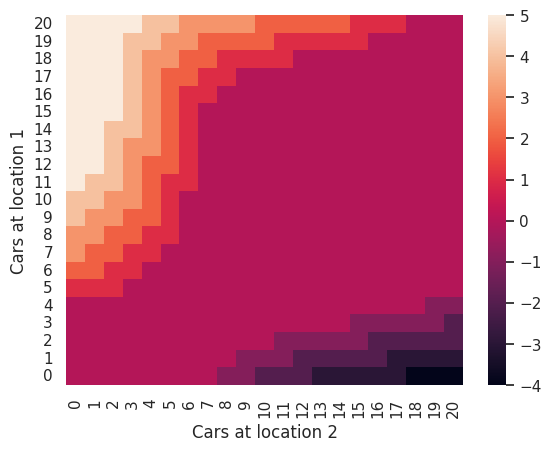

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

f, ax = plt.subplots()
sns.heatmap(visual_policy, ax=ax).invert_yaxis()
ax.set_xlabel("Cars at location 2")
ax.set_ylabel("Cars at location 1")

Text(46.25, 0.5, 'Cars at location 1')

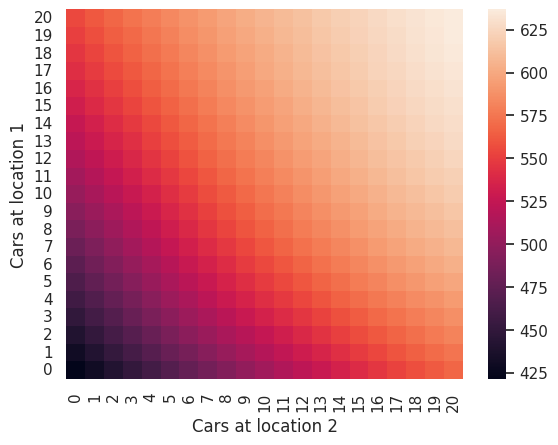

In [8]:
visual_values = iterator.values.reshape((21, 21))
f, ax = plt.subplots()
sns.heatmap(visual_values, ax=ax).invert_yaxis()
ax.set_xlabel("Cars at location 2")
ax.set_ylabel("Cars at location 1")

In [9]:
transitions = np.zeros((num_states, num_states, num_actions))
rewards = np.zeros_like(transitions) - 2 * (np.abs(np.arange(-5, 6)) - np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]))
policy = np.ones((num_states, num_actions), dtype=float) / num_actions

for s in tqdm(range(num_states), desc="s"):
    # Number of cars in first location
    s1 = s // 21
    # Number of cars in second location
    s2 = s % 21
    for a in range(num_actions):
        raw_cars_moved = a - 5
        cars_moved = min(s1, raw_cars_moved)
        cars_moved = max(-s2, cars_moved)
        c1am = min(20, s1 - cars_moved)
        c2am = min(20, s2 + cars_moved)
        cost = 0
        if c1am > 10:
            cost += 4
        if c2am > 10:
            cost += 4

        expreq1 = 0
        probs1 = np.zeros(21)
        for req1 in range(0, c1am + 1):
            c1areq = c1am - req1
            if c1areq == 0:
                p_req1 = poisson_n_or_more(lmbd_req1, req1)
            else:
                p_req1 = poisson(lmbd_req1, req1)
            expreq1 += req1 * p_req1

            for ret1 in range(0, 21 - c1areq):
                c1aret = c1areq + ret1
                if c1aret == 20:
                    p_ret1 = poisson_n_or_more(lmbd_ret1, ret1)
                else:
                    p_ret1 = poisson(lmbd_ret1, ret1)
                probs1[c1aret] += p_req1 * p_ret1

        expreq2 = 0
        probs2 = np.zeros(21)
        for req2 in range(0, c2am + 1):
            c2areq = c2am - req2
            if c2areq == 0:
                p_req2 = poisson_n_or_more(lmbd_req2, req2)
            else:
                p_req2 = poisson(lmbd_req2, req2)
            expreq2 += req2 * p_req2

            for ret2 in range(0, 21 - c2areq):
                c2aret = c2areq + ret2
                if c2aret == 20:
                    p_ret2 = poisson_n_or_more(lmbd_ret2, ret2)
                else:
                    p_ret2 = poisson(lmbd_ret2, ret2)
                probs2[c2aret] += p_req2 * p_ret2

        for s1_ in range(21):
            for s2_ in range(21):
                s_ = 21 * s1_ + s2_
                transitions[s,s_,a] = probs1[s1_] * probs2[s2_]
                rewards[s,s_,a] += (expreq1 + expreq2) * 10 - cost

s: 100%|███████████████████████████████████████████████████████████████| 441/441 [00:01<00:00, 374.26it/s]


In [10]:
# Sanity check: Going from some state to any other state when taking
# an action should always be 1.
np.sum(transitions[48,:,:], axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [11]:
iterator = PolicyIteration(transitions, rewards, discount, policy)
iterator.find_optimal_policy()
visual_policy = np.argmax(iterator.policy, axis=2).reshape((21, 21)) - 5

Text(46.25, 0.5, 'Cars at location 1')

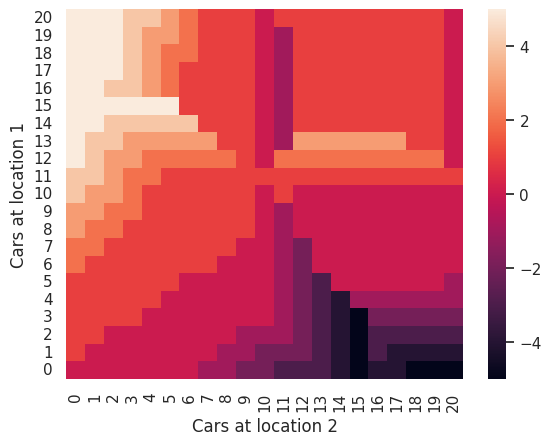

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

f, ax = plt.subplots()
sns.heatmap(visual_policy, ax=ax).invert_yaxis()
ax.set_xlabel("Cars at location 2")
ax.set_ylabel("Cars at location 1")

Text(46.25, 0.5, 'Cars at location 1')

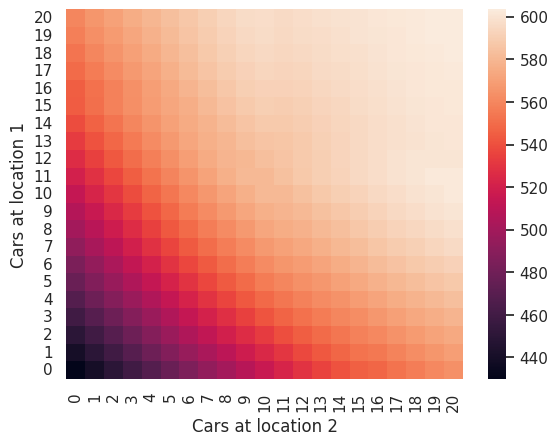

In [13]:
visual_values = iterator.values.reshape((21, 21))
f, ax = plt.subplots()
sns.heatmap(visual_values, ax=ax).invert_yaxis()
ax.set_xlabel("Cars at location 2")
ax.set_ylabel("Cars at location 1")